<a href="https://colab.research.google.com/github/SeongwonTak/TIL_swtak/blob/master/graduateschool_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graduate School Admission Prediction

Linear Regression 관련 내용 추가적인 연습을 위해
간단한 데이터셋을 바탕으로 재복습을 진행한다.

이번에 사용할 데이터는 미 대학원 진학 관련 데이터이다.

## 문제설정
사용할 데이터셋은 https://www.kaggle.com/mohansacharya/graduate-admissions이다.

다음의 변수들을 바탕으로 Admission 받을 확률을 예측하고자 한다.

1. GRE Scores ( out of 340 )
2. TOEFL Scores ( out of 120 )
3. University Rating ( out of 5 )
4. Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
5. Undergraduate GPA ( out of 10 )
6. Research Experience ( either 0 or 1 )

이를 바탕으로 예측해야 하는 변수는
Chance of Admit ( ranging from 0 to 1 )

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns

## 데이터셋 준비

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Admission_Predict.csv')

In [ ]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


이번에는 Train Set과 Test Set을 나눠서 진행할 것이다.
Train Set에는 400개의 데이터, Test Set에는 100개의 데이터가 들어가게 배정하려고 한다.
하지만, 이 전에 필요없는 변수인 Serial No.를 없애고 변수명을 간략화 하자.

In [4]:
df.drop('Serial No.', axis = 1, inplace = True)

In [5]:
df.columns = ['GRE', 'TOEFL', 'Univ_Rate', 'SOP', 'LOR', 'CGP', 'Research', 'Chance_Admit']

이제 train set, test set을 분류하자.
그 전에 당연히 df_X, df_Y도 분류해야 할 것이다.

In [6]:
from sklearn.model_selection import train_test_split

df_X = df.iloc[:,0:7]
df_Y = df.iloc[:,7]

X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, 
                                                    test_size=0.2,
                                                    random_state=99)

## 데이터셋 탐색

본격적인 전처리 전에 데이터셋을 탐색해보자.

In [ ]:
df.isna().sum()

GRE             0
TOEFL           0
Univ_Rate       0
SOP             0
LOR             0
CGP             0
Research        0
Chance_Admit    0
dtype: int64

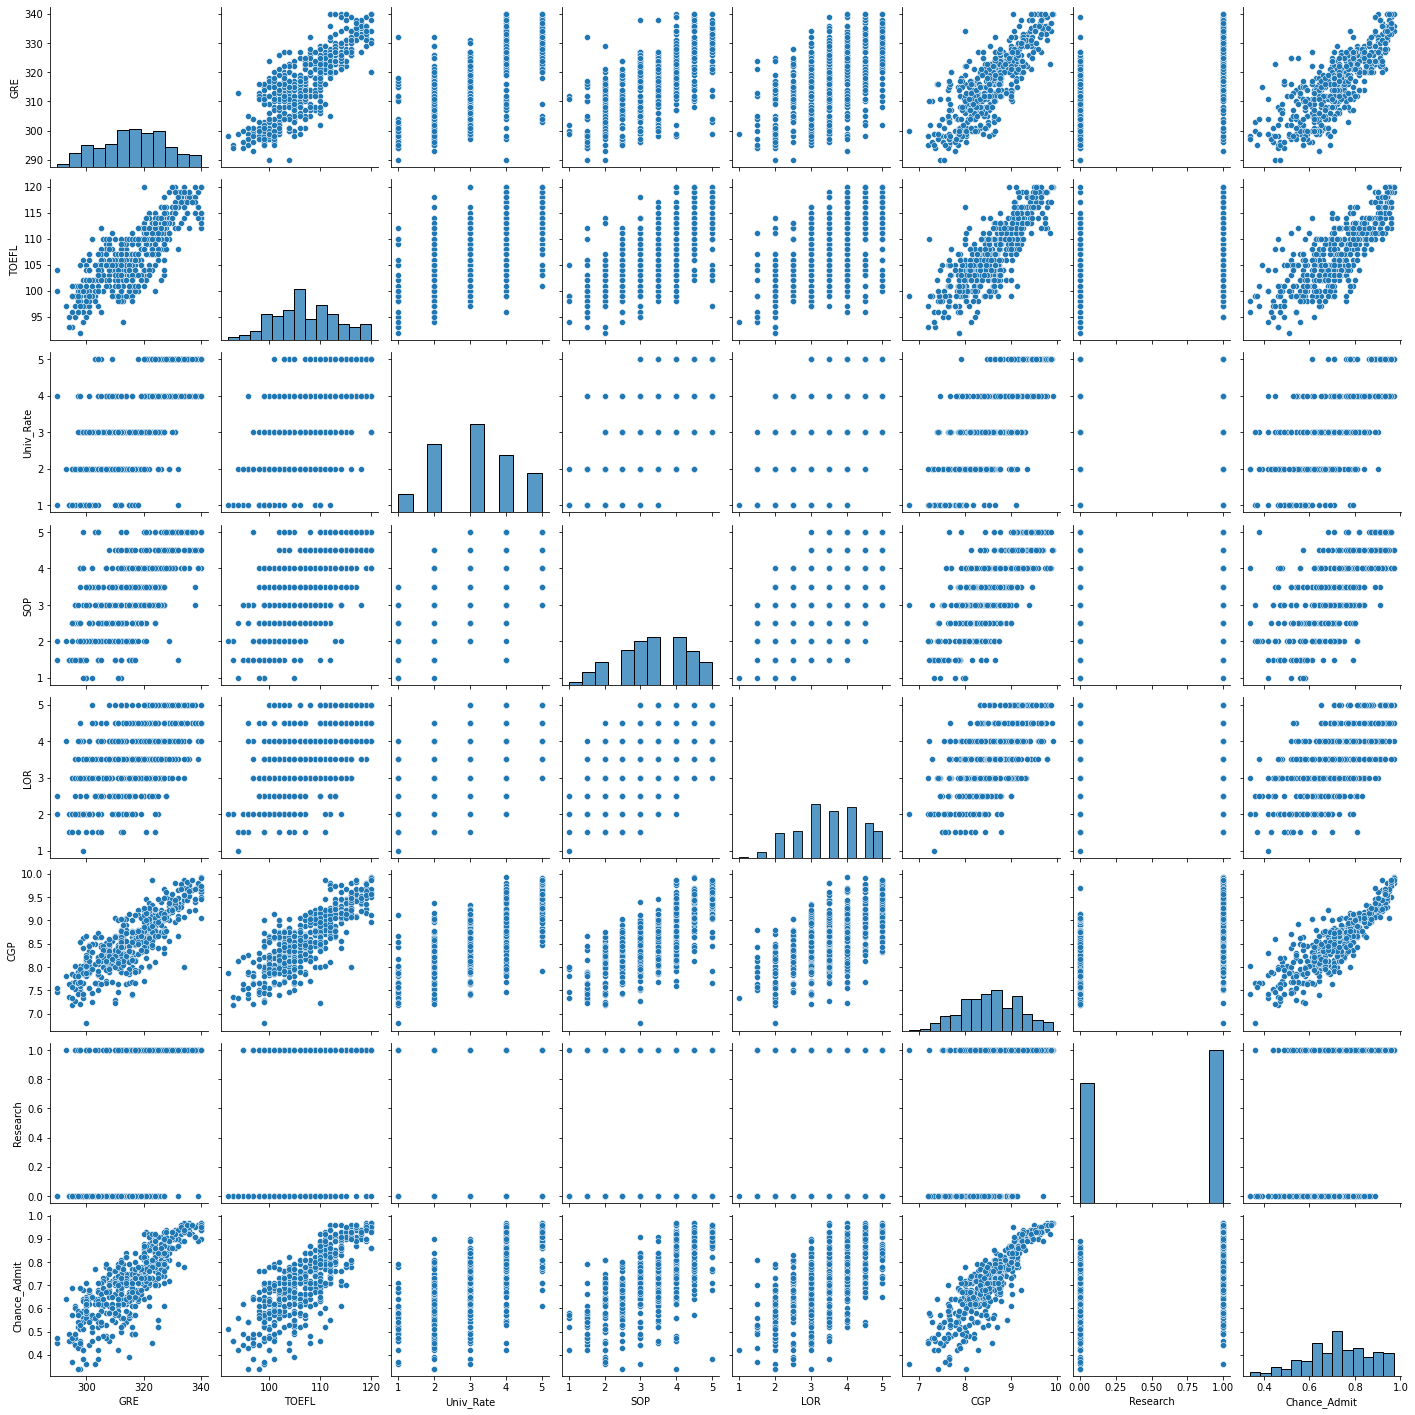

In [ ]:
sns.pairplot(df)

In [ ]:
df.corr()

,GRE,TOEFL,Univ_Rate,SOP,LOR,CGP,Research,Chance_Admit
GRE,1.000000,0.827200,0.635376,0.613498,0.524679,0.825878,0.563398,0.810351
TOEFL,0.827200,1.000000,0.649799,0.644410,0.541563,0.810574,0.467012,0.792228
Univ_Rate,0.635376,0.649799,1.000000,0.728024,0.608651,0.705254,0.427047,0.690132
SOP,0.613498,0.644410,0.728024,1.000000,0.663707,0.712154,0.408116,0.684137
LOR,0.524679,0.541563,0.608651,0.663707,1.000000,0.637469,0.372526,0.645365
CGP,0.825878,0.810574,0.705254,0.712154,0.637469,1.000000,0.501311,0.882413
Research,0.563398,0.467012,0.427047,0.408116,0.372526,0.501311,1.000000,0.545871
Chance_Admit,0.810351,0.792228,0.690132,0.684137,0.645365,0.882413,0.545871,1.000000


## 데이터 전처리

운 좋게도 대부분의 변수가 정규분포를 띄고 있음을 알 수 있다.
주의해야 할 점은 범주형인 변수가 몇 개 보인다. (5점 만점 관련)

어떻게 전처리를 할지 계획을 세워보자.
- 토플, GRE, GPA는 정규화를 시행한다.
  이 때, 정규화를 실시할 때, Train set에서 표준화로 쓴 평균값 등을 Test Set에 동일하게 적용하려고 한다.
- Univ_Rate, SOP, LOR은 두 가지 방법의 전처리가 떠오른다.
  - One-Hot-Encoding
  - 값 / 최댓값을 나눠, 0~1 사이의 값이 되게 해준다.

X_train을 전처리해보자.

In [ ]:
X_train

,GRE,TOEFL,Univ_Rate,SOP,LOR,CGP,Research
2,316,104,3,3.0,3.5,8.00,1
125,300,100,3,2.0,3.0,8.66,1
430,311,104,3,4.0,3.5,8.13,1
416,315,104,3,4.0,2.5,8.10,0
324,315,104,3,3.0,2.5,8.33,0
...,...,...,...,...,...,...,...
201,315,110,2,3.5,3.0,8.46,1
168,293,97,2,2.0,4.0,7.80,1
185,327,113,4,4.5,4.5,9.11,1
35,320,110,5,5.0,5.0,9.20,1


In [ ]:
X_train['Univ_Rate'] = X_train['Univ_Rate'].apply(lambda x : x / 5)
X_train['SOP'] = X_train['SOP'].apply(lambda x : x / 5)
X_train['LOR'] = X_train['LOR'].apply(lambda x : x / 5)

In [ ]:
X_test['Univ_Rate'] = X_test['Univ_Rate'].apply(lambda x : x / 5)
X_test['SOP'] = X_test['SOP'].apply(lambda x : x / 5)
X_test['LOR'] = X_test['LOR'].apply(lambda x : x / 5)

GRE. TOEFL, CGP는 표준화를 진행하자.

In [ ]:
std_list = ['GRE', 'TOEFL', 'CGP']
for i in std_list:
  mean = np.mean(X_train[i])
  std = np.std(X_train[i])
  X_train[i] = X_train[i].apply(lambda x : (x - mean)/ std)
  X_test[i] = X_test[i].apply(lambda x : (x - mean)/ std)

표준화가 완료되었다. 이제 선형회귀를 적용해보자.

## 선형회귀의 적용

먼저  train set에 대해서 선형회귀의 효과를 확인해보자.

In [11]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, Y_train)
print( "coefficient=", reg.coef_ )
print( "intercept=", reg.intercept_ )
print( "R²=", reg.score(X_train, Y_train) )

coefficient= [0.020112   0.01716761 0.02636555 0.03396884 0.08816674 0.06810808
 0.0236434 ]
intercept= 0.6047546101306134
R²= 0.8130260614589513


확인결과, 추천서와 학부성적이 가장 큰 변수를 가지고 있고 영어 성적이나 연구결과는 상대적으로 변수의 중요도가 낮음을 알 수 있다.
Test Set에 대해서도 비슷한 결과를 얻는지 확인해보자.

In [12]:
result = reg.predict(X_test)
result

array([0.56620985, 0.64042022, 0.71064434, 0.69796331, 0.79317359,
       0.8662753 , 0.78158416, 0.8940434 , 0.62979167, 0.60278603,
       0.68698058, 0.91756258, 0.70729952, 0.57978447, 0.74350994,
       0.78226382, 0.72288304, 0.46289888, 0.92757486, 0.73062234,
       0.81588538, 0.61962357, 0.65057303, 0.84607778, 0.75844354,
       0.88328543, 0.93815054, 0.77204288, 0.83716982, 0.72990085,
       0.83770932, 0.77048033, 0.59947652, 0.69971379, 0.63351286,
       0.79842979, 0.55555936, 0.56706547, 0.66133036, 0.95927095,
       0.6463121 , 0.9113684 , 0.59079018, 0.67919444, 0.75118341,
       0.50149414, 0.81042036, 0.85422067, 0.71452746, 0.59221834,
       0.69908858, 0.80444874, 0.76525227, 0.80426279, 0.65266472,
       0.65420095, 0.85850398, 0.80228717, 0.88300523, 0.77644857,
       0.49427638, 0.71406203, 0.77337523, 0.69452081, 0.73315226,
       0.69088098, 0.83351528, 0.79219494, 0.80229243, 0.71791031,
       0.514131  , 0.81159771, 0.86099017, 0.84699099, 0.72153

In [14]:
from sklearn.metrics import r2_score
r2_score(Y_test, result)

0.8527660106232576